In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import seaborn as sns

In [3]:
plt.rcParams["figure.figsize"] = (15,10)

In [4]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [5]:
cols = ['AIR_TEMP', 'WIND_SPEED', 'ATMO_PRESSURE', 'HUMIDITY', 'RAIN_FALL']
colname = ['AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)','HUMIDITY(%)', 'RAIN_FALL(mm)']

In [6]:
master_data = pd.DataFrame()

In [7]:
df = pd.read_csv(root+'corrected/west_bengal.csv')

In [8]:
df = pd.read_csv(root+'corrected/west_bengal.csv')

In [9]:
def run_Generator(idx):
#   #####################################################
#   ## Loading & Getting predictions from model
#   #####################################################
  df = pd.read_csv(root+'corrected/west_bengal.csv')
  datelist = df['DATE']
  df['DATE']= pd.to_datetime(df['DATE'])
  df = df.drop(columns='DATE')
  training_set = df
  sc = StandardScaler()
  training_set_scaled = sc.fit_transform(training_set)
  sc_predict = StandardScaler()
  sc_predict.fit_transform(training_set.iloc[:, idx:idx+1])
  X_train = []
  y_train = []
  n_future = 1   
  n_past = 60   
  for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, idx])
  X_train, y_train = np.array(X_train), np.array(y_train)
  model = tf.keras.models.load_model(root+'ISRO_MODE/'+cols[idx]+'.h5')
  predictions_train = model.predict(X_train[n_past:])
  y_pred_train = sc_predict.inverse_transform(predictions_train)
  df['DATE'] = datelist 
  y_pred_train[0:].reshape(-1).shape
  hypermodel = tf.keras.models.load_model(root+'ISRO_MODE/SCALERS/'+cols[idx]+'.h5')
  predictions = hypermodel.predict(y_pred_train[0:])
  master_data['act'+ colname[idx]] = df[colname[idx]][2 * n_past + n_future -1:]
  master_data['predic'+ colname[idx]] = predictions
  master_data.set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

In [10]:
# begin = '2019-09-29'
# end = '2019-09-30'
for i in tqdm(range(5)):
  print()
  run_Generator(i)
  print()

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:15<01:01, 15.31s/it]

 40%|████      | 2/5 [00:33<00:51, 17.25s/it]

 60%|██████    | 3/5 [00:43<00:27, 13.60s/it]

 80%|████████  | 4/5 [00:51<00:11, 11.38s/it]

100%|██████████| 5/5 [00:57<00:00, 11.57s/it]

In [11]:
datelist = pd.to_datetime(df['DATE'])
# master_data.set_index(pd.Series(datelist[2 * 60 + 1 -1:]))
master_data['DATE'] = datelist

In [12]:
master_data['mse'] = 0.0
master_data.reset_index()
for index, row in master_data.iterrows():
  rms = 0
  # print(df['act'+ colname[0]][])
  for i in range(5):
    rms = rms + abs(row['act'+ colname[i]] - row['predic'+ colname[i]])
  master_data['mse'][index] =  rms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# master_data.sort_values(by=['mse'], inplace=True)
master_data.head(10)

,actAIR_TEMP(°C),predicAIR_TEMP(°C),actWIND_SPEED(m/s),predicWIND_SPEED(m/s),actATMO_PRESSURE(hpa),predicATMO_PRESSURE(hpa),actHUMIDITY(%),predicHUMIDITY(%),actRAIN_FALL(mm),predicRAIN_FALL(mm),DATE,mse
120,30.650000,30.027340,1.300000,1.036428,0.0,0.851790,60.100000,58.977173,150.500000,144.009171,2015-11-06 10:30:00,9.351679
121,31.300000,30.328863,1.100000,1.078604,0.0,1.201796,49.600000,56.072342,150.500000,150.011047,2015-11-06 11:30:00,9.155624
122,31.400000,30.322451,0.650000,1.055721,0.0,1.810496,45.600000,47.163940,150.500000,160.018509,2015-11-06 12:30:00,14.376215
123,0.000000,30.126122,1.250000,0.943990,0.0,0.000000,44.900000,45.592796,150.500000,170.400314,2015-11-06 13:30:00,51.025243
124,31.400000,12.112979,1.050000,0.989796,0.0,191.726425,45.550000,44.641968,150.500000,192.560532,2015-11-06 14:30:00,254.042214
125,31.233333,30.111277,0.600000,0.948883,0.0,0.000000,47.933333,49.650055,304.333333,191.501419,2015-11-06 15:30:00,116.019575
126,29.500000,29.394003,0.600000,0.775867,0.0,0.000000,54.000000,50.530079,304.333333,283.896729,2015-11-06 16:30:00,24.188390
127,28.500000,28.958899,0.333333,0.674830,0.0,0.000000,59.766667,60.646221,304.333333,293.971344,2015-11-06 17:30:00,12.041939
128,27.800000,28.476662,0.000000,0.502930,0.0,0.000000,66.066667,66.917549,304.333333,299.226959,2015-11-06 18:30:00,7.136848
129,27.233333,28.071129,0.000000,0.319182,0.0,0.000000,68.466667,72.317162,304.333333,297.976410,2015-11-06 19:30:00,11.364396


In [14]:
df = master_data[['DATE', 'mse']]

In [15]:
df

,DATE,mse
120,2015-11-06 10:30:00,9.351679
121,2015-11-06 11:30:00,9.155624
122,2015-11-06 12:30:00,14.376215
123,2015-11-06 13:30:00,51.025243
124,2015-11-06 14:30:00,254.042214
...,...,...
37981,2020-04-30 23:30:00,36.625438
37982,2020-05-01 00:30:00,35.151284
37983,2020-05-01 01:30:00,33.758330
37984,2020-05-01 02:30:00,30.446453


In [16]:
temp_df = df

In [18]:
aggregation_functions = {'mse': 'sum'}
df_new = temp_df.groupby(temp_df['DATE'].dt.date).aggregate(aggregation_functions)

In [19]:
df_new

,mse
DATE,
2015-11-06,591.441927
2015-11-07,997.725736
2015-11-08,1054.284973
2015-11-09,749.881610
2015-11-10,2775.961138
...,...
2020-04-27,1395.410656
2020-04-28,1151.108747
2020-04-29,1348.339256


In [21]:
df_new.sort_values(by=['mse'], inplace = True)
df_new.head(10)

,mse
DATE,
2020-05-01,127.313876
2017-11-25,155.706216
2016-08-02,185.690306
2016-08-12,209.239633
2016-08-05,235.451950
2017-12-06,237.796713
2016-08-06,253.182087
2017-12-03,266.985975
2017-11-28,272.114129


In [22]:
df_new.describe()

,mse
count,1639.000000
mean,1685.721737
std,1243.996164
min,127.313876
25%,933.255552
50%,1276.061199
75%,1849.882319
max,9499.846543


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


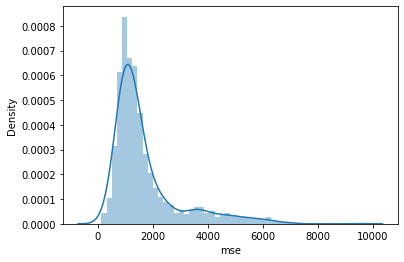

In [25]:
sns.distplot(df_new['mse'])

In [26]:
def generator_plots(datestart, dateend, idx):
#   #####################################################
#   ## Loading & Getting predictions from model
#   #####################################################
  df = pd.read_csv(root+'corrected/west_bengal.csv')
  date_samples = df.loc[(df['DATE']>=datestart) & (df['DATE']<=dateend)]['DATE']
  datelist = df['DATE']
  df['DATE']= pd.to_datetime(df['DATE'])
  df = df.drop(columns='DATE')
  training_set = df
  sc = StandardScaler()
  training_set_scaled = sc.fit_transform(training_set)
  sc_predict = StandardScaler()
  sc_predict.fit_transform(training_set.iloc[:, idx:idx+1])
  X_train = []
  y_train = []
  n_future = 1   
  n_past = 60   
  for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, idx])
  X_train, y_train = np.array(X_train), np.array(y_train)
  model = tf.keras.models.load_model(root+'ISRO_MODE/'+cols[idx]+'.h5')
  predictions_train = model.predict(X_train[n_past:])
  y_pred_train = sc_predict.inverse_transform(predictions_train)
  df['DATE'] = datelist 
  y_pred_train[0:].reshape(-1).shape
  hypermodel = tf.keras.models.load_model(root+'ISRO_MODE/SCALERS/'+cols[idx]+'.h5')
  predictions = hypermodel.predict(y_pred_train[0:])
  ########################################################
  PREDICTION_TRAIN = pd.DataFrame(predictions, columns=[colname[idx]]).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
  df_samples = pd.DataFrame(columns=['DATETIME', 'ACTUAL '+colname[idx], 'PREDICTED '+colname[idx]])
  for x in tqdm(date_samples):
    act = df.loc[df['DATE'] == x][colname[idx]].tolist()[0]
    predic = PREDICTION_TRAIN.loc[x][colname[idx]]
    df_samples.loc[len(df_samples.index)] = [x, act, predic] 
  df_samples.set_index('DATETIME')[['ACTUAL '+colname[idx], 'PREDICTED '+colname[idx]]].plot()

  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:09<00:37,  9.36s/it]


 40%|████      | 2/5 [00:16<00:24,  8.06s/it]


 60%|██████    | 3/5 [00:24<00:16,  8.06s/it]


 80%|████████  | 4/5 [00:31<00:07,  7.59s/it]


100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


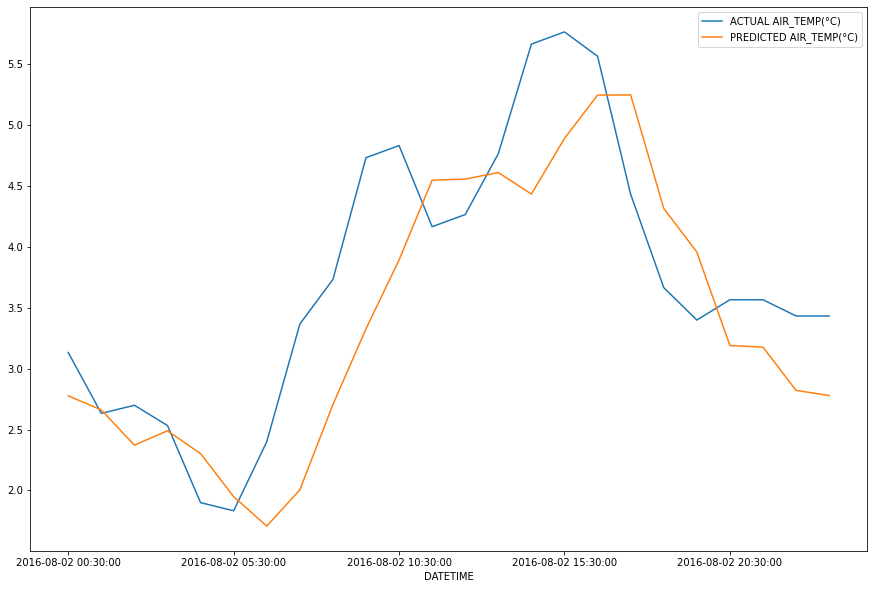

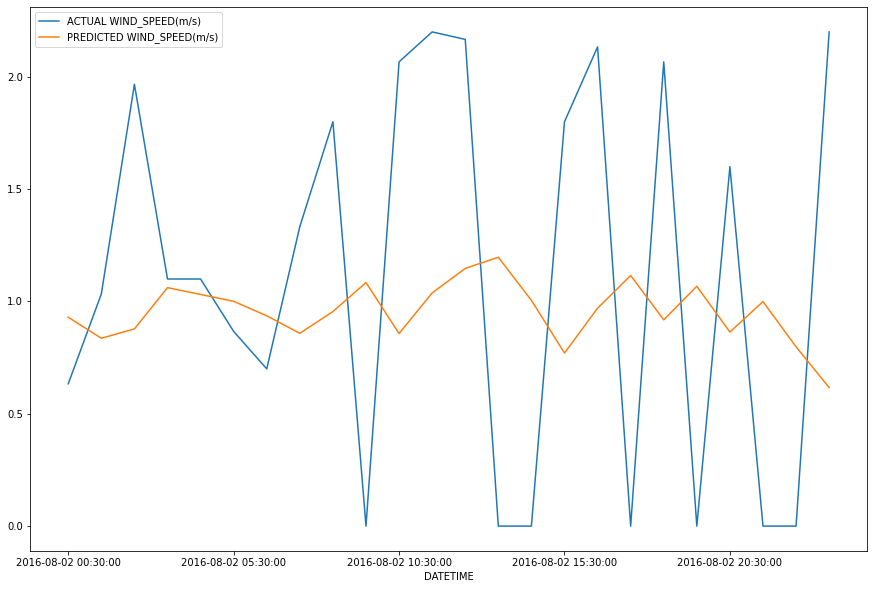

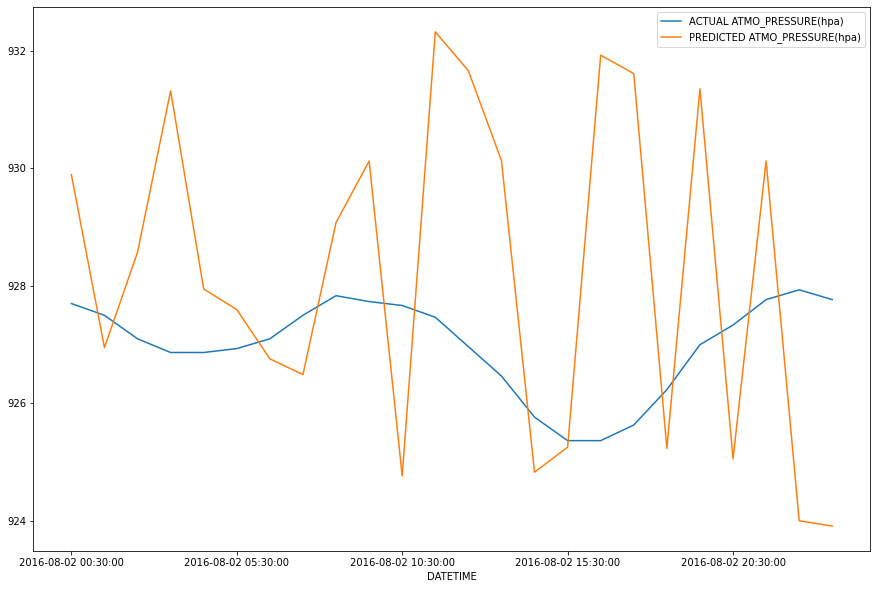

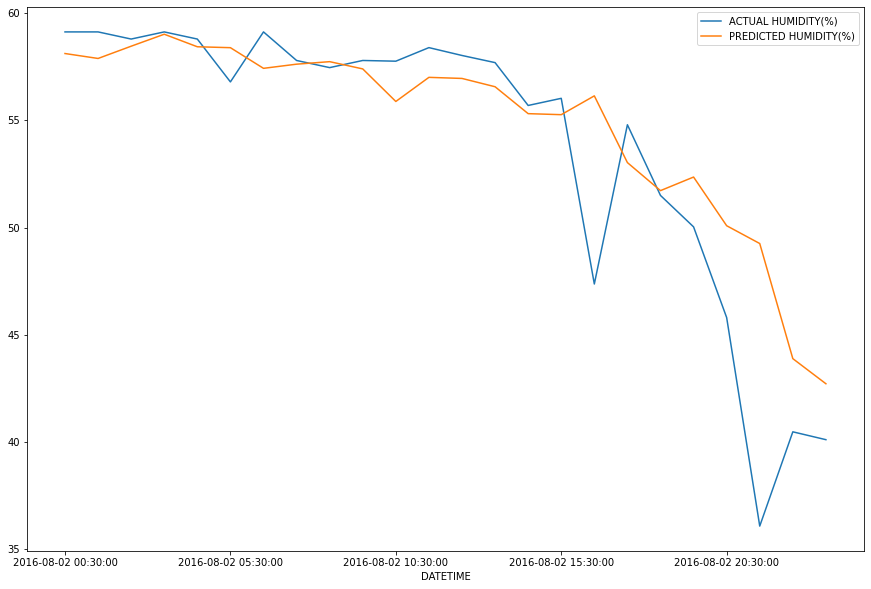

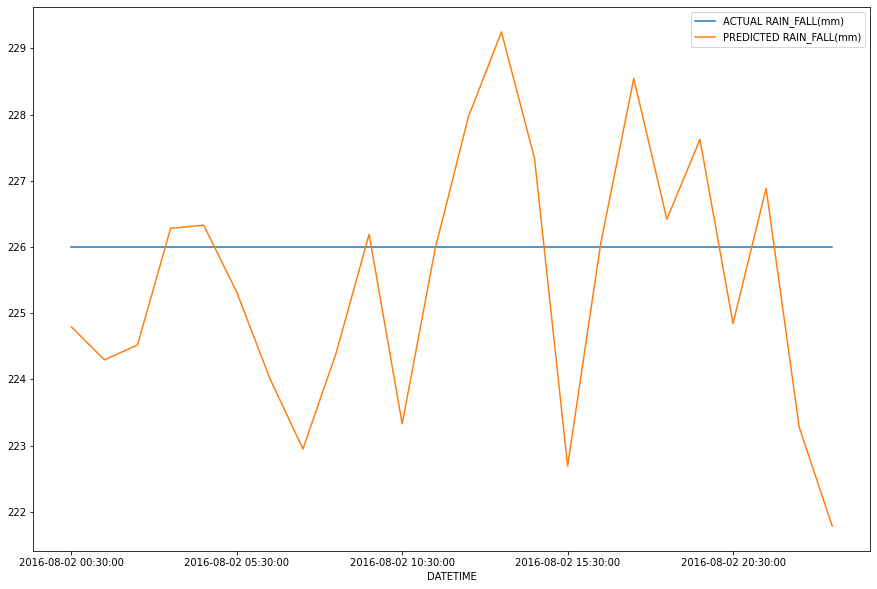

In [29]:
begin = '2016-08-02'
end = '2016-08-03'
plt.rcParams["figure.figsize"] = (15,10)
for i in tqdm(range(5)):
  print()
  generator_plots(begin, end,i)
  print()